From current implimentations of local/ ML clustering improvede segmentations. I now strive to improve the functionality of this approach by minimalizing user input. For this test case we work with simple 3d images of phagosomes with fluorescent actin. In these images we have three effective clusters we can identify i.e noise/BG, dim actin/ actin filiments, and bright actin/podosomes.

Load test case 1 time point into session using this seq. in chimerax command prompt-

open E:/Janelia/20250122cs6cell2/decon/scan_Cam0_ch0_tile0_t0012_decon.tif;
open E:/Janelia/20250122cs6cell2/decon/scan_Cam0_ch1_tile0_t0012_decon.tif;
marker connected #2;
marker change #3 radius 10;
marker delete #3:9;
marker delete #3:8;
marker delete #3:13;
marker delete #3:17;
marker delete #3:11;
marker delete #3:10;
marker delete #3:15;
marker delete #3:16;
marker delete #3:14;
marker delete #3:12;
marker delete #3:18;
marker delete #3:6;
marker delete #3:3;
marker delete #3:2;
marker delete #3:5;
marker delete #3:1;
ui tool show Shell;

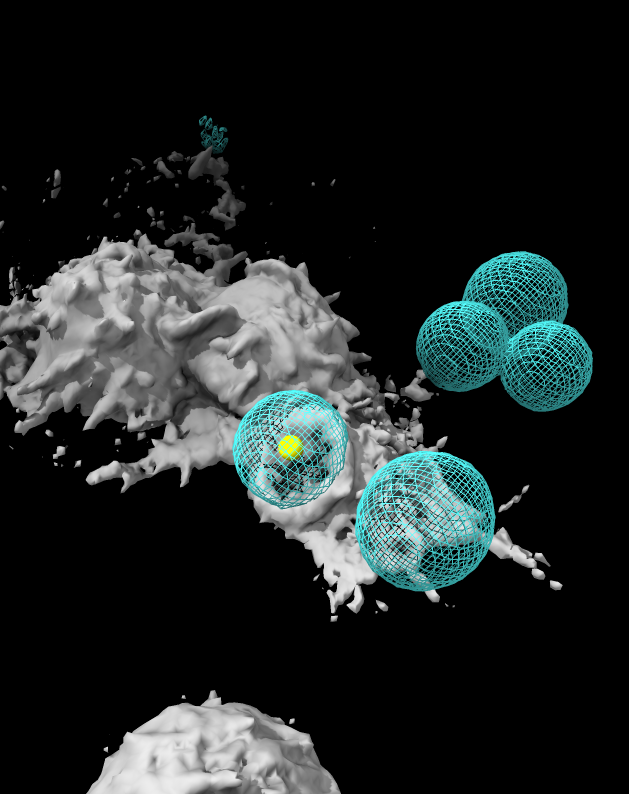

Using the chimeraX shell: 
Imports for approach-

In [ ]:
from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data
import itertools
import numpy
import scipy
import skimage
from time import time
import sklearn
import matplotlib

Specify marker and RAW

In [ ]:
img=session.models[1].volume.full_matrix().copy()
p= session.models[4].atoms.coords
size=(1,1,2)

Defining inital parameters.

In [ ]:
"""background = bg; both noise and "dim objects"""
bg = img.max()*.2

"""Proximity to centroid of target of interest"""
p=numpy.round(p).astype('int64')
"""Defining marker coords in pixel space"""
a = (p[0,0]/size[0]).astype('int64')
b = (p[0,1]/size[1]).astype('int64')
c = (p[0,2]/2).astype('int64')

"""Make array of pixel location from marker, Raidus in PIXELS"""
cartimap = numpy.zeros(img.shape)

iterable = [numpy.linspace(c-32,c+32, 65), numpy.linspace(b-120, b+120,241), numpy.linspace(a-120, a+120, 241)]
indexcarti=numpy.array(list(itertools.product(*(iterable),repeat=1)),dtype='int')
spaceZ,spaceY,spaceX = numpy.split(indexcarti,3,1)
radius=numpy.sqrt(((((spaceZ)-c)*2)**2)+((spaceY-b)**2)+((spaceX-a)**2))

cartimap[spaceZ,spaceY,spaceX]=radius

cl=numpy.nanmean(img[(cartimap>25)&(cartimap<50)])

QueryMap = numpy.zeros(img.shape)
QueryMap[(cartimap>25)&(cartimap<70)]=1
QuerySpace = numpy.where(QueryMap==1)
QueryX = QuerySpace[0]
QueryY = QuerySpace[1]
QueryZ = QuerySpace[2]
QueryInd=numpy.array([QueryX, QueryY, QueryZ],dtype='int')

Image of radi- from the marker represented as a "heat" map

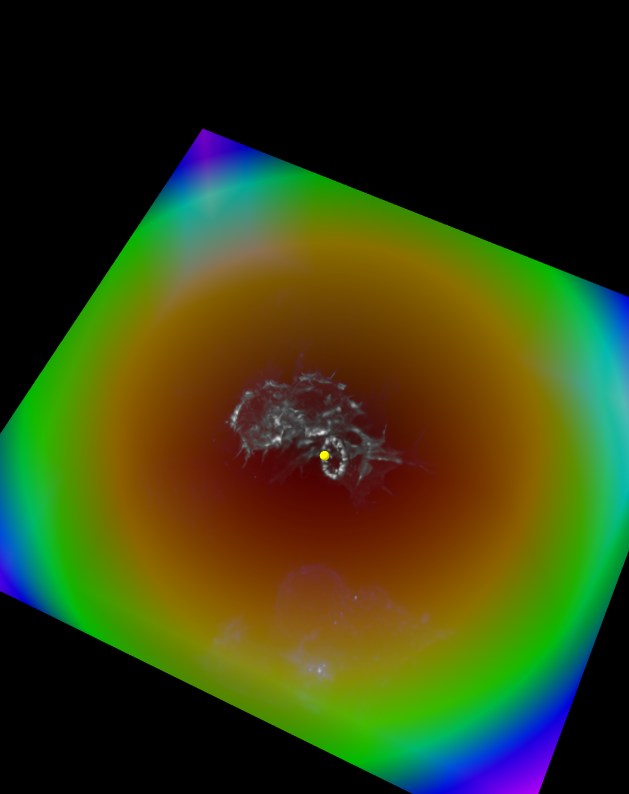

KD tree

In [ ]:
qtree=scipy.spatial.KDTree(QueryInd.T)
neoghborhoods = qtree.query_ball_point(QueryInd.T, r=4, workers=-1)

Smoothing objects

Local Thresholding using an adjusted berson method

In [ ]:
"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=img-(numpy.zeros(numpy.shape(img))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask

In [ ]:
"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=img-(numpy.zeros(numpy.shape(img))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask

lp=numpy.zeros(numpy.shape(img))
elp=numpy.zeros(numpy.shape(img))

def loop_ROI(q,neoghborhoods,l,mask):

    for ind in range (0,numpy.shape(neoghborhoods)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q.T[neoghborhoods[ind]],axis=1),3,1)

        x,yy,z = q.T[ind]
        standardD = numpy.nanstd(l[tx,ty,tz])*0.05 
        Thresh= ((((numpy.nanmax(l[tx,ty,tz])*0.9)-numpy.nanmin(l[tx,ty,tz])*2))/2)+standardD
        contrast= (numpy.nanmax(l[tx,ty,tz])-numpy.nanmin(l[tx,ty,tz])) 

        lp[x,yy,z] = (contrast > (0.7*cl)) * (l[x,yy,z] >= Thresh*.9)
        elp[x,yy,z] = lp[x,yy,z]*mask[x,yy,z]
    return elp, lp

elp,lp = loop_ROI(q = indexcarti, neoghborhoods = neoghborhoods,l=l,mask=mask)

In [ ]:
s=time()
"""background = bg; both noise and "dim objects"""
bg = img.max()*.2

"""Proximity to centroid of target of interest"""
p=numpy.round(p).astype('int64')
"""Defining marker coords in pixel space"""
a = (p[0,0]/size[0]).astype('int64')
b = (p[0,1]/size[1]).astype('int64')
c = (p[0,2]/2).astype('int64')

"""Make array of pixel location from marker, Raidus in PIXELS"""
cartimap = numpy.zeros(img.shape)

iterable = [numpy.linspace(c-32,c+32, 65), numpy.linspace(b-120, b+120,241), numpy.linspace(a-120, a+120, 241)]
indexcarti=numpy.array(list(itertools.product(*(iterable),repeat=1)),dtype='int')
spaceZ,spaceY,spaceX = numpy.split(indexcarti,3,1)
radius=numpy.sqrt(((((spaceZ)-c)*2)**2)+((spaceY-b)**2)+((spaceX-a)**2))

cartimap[spaceZ,spaceY,spaceX]=radius

cl=numpy.nanmean(img[(cartimap>25)&(cartimap<50)])

QueryMap = numpy.zeros(img.shape)
QueryMap[(cartimap>25)&(cartimap<70)]=1
QuerySpace = numpy.where(QueryMap==1)
QueryX = QuerySpace[0]
QueryY = QuerySpace[1]
QueryZ = QuerySpace[2]
QueryInd=numpy.array([QueryX, QueryY, QueryZ],dtype='int')

qtree=scipy.spatial.KDTree(QueryInd.T)
neoghborhoods = qtree.query_ball_point(QueryInd.T, r=4, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=img-(numpy.zeros(numpy.shape(img))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=img-(numpy.zeros(numpy.shape(img))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask
l[l<=175]=numpy.nan
lp=numpy.zeros(numpy.shape(img))
elp=numpy.zeros(numpy.shape(img))

def loop_ROI(q,neoghborhoods,l,mask):

    for ind in range (0,numpy.shape(neoghborhoods)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q.T[neoghborhoods[ind]],axis=1),3,1)

        x,yy,z = q.T[ind]
        standardD = numpy.nanstd(l[tx,ty,tz])*0.05 
        Thresh= ((((numpy.nanmax(l[tx,ty,tz])*0.9)-numpy.nanmin(l[tx,ty,tz])*2))/2)+standardD
        contrast= (numpy.nanmax(l[tx,ty,tz])-numpy.nanmin(l[tx,ty,tz])) 

        lp[x,yy,z] = (contrast > (0.7*cl)) * (l[x,yy,z] >= Thresh*.9)
        elp[x,yy,z] = lp[x,yy,z]*mask[x,yy,z]
    return elp, lp

elp,lp = loop_ROI(q = QueryInd, neoghborhoods = neoghborhoods,l=l,mask=mask)
st=time()

timer=(s-st)/60
timer

author note: 20250807 yml 

Implimentation of  new iteration of the script for the adapted berson's method offers two new improvements. The information passed no longer passes iterations of 2D sub regions of the ROI and opperates fully on the 3D data contributing to the second improvement, which is an 3-4X improvemnt on the time to work on a single image, lastly the scaling factors are nolonger being washed by low intensity pixels (true noise). The above provides a scafold for segmenting bright pxels in a spherical roi without a internal ROI (its a hallow ball). This version of the script is 4X fast than the one prior (runs in about 1 min).

Fluorescent data (gray), Nex mask (green vol), old mask blue mesh

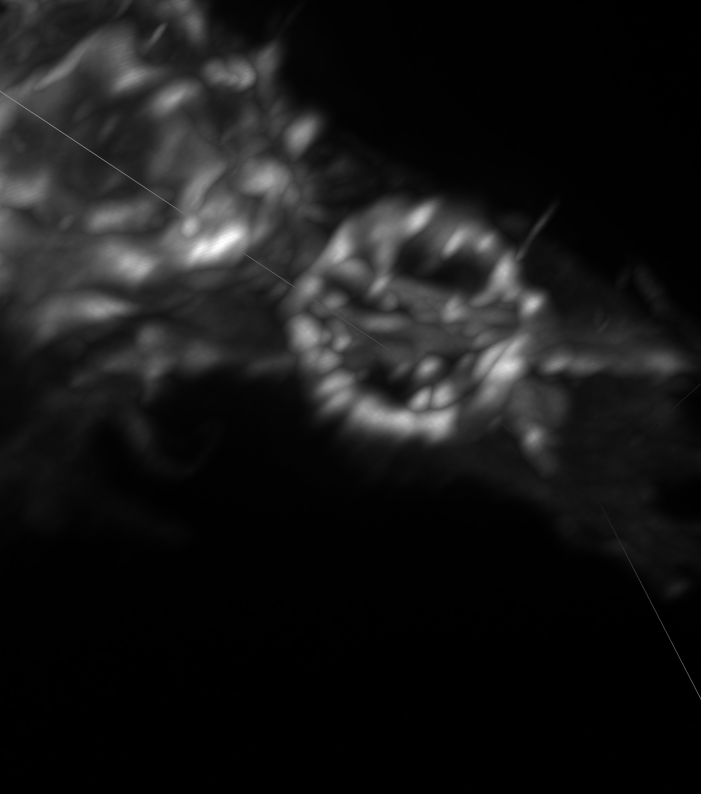

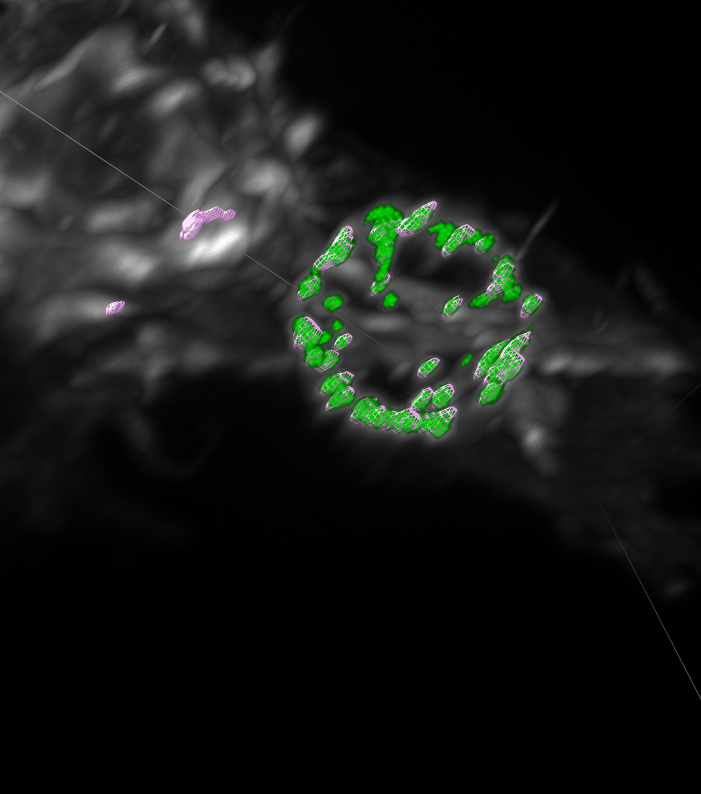

Next addiontion is to incorporate pixel clustering in a efficent and intenligent manner.

In [ ]:
s=time()
y=session.models[1].volume.full_matrix().copy()
p= session.models[4].atoms.coords

def background(y):
    bg=numpy.average(y)+(2*numpy.std(y))
    return bg
bg= background(y=y[110:190,423:577,515:673])

telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 55
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

lp=numpy.zeros(numpy.shape(y))
elp=numpy.zeros(numpy.shape(y))

for on in range (110,190):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=2)*mask

    def loop_ROI(q,index,l,mask):

        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])*1))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

    elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask)
    st=time()
    timer=st-s